In [1]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import georaster
from osgeo import osr
import scipy.io

mat = scipy.io.loadmat('./rasters/midm.mat')
ref = osr.SpatialReference()
# Import from Proj.4

# Or EPSG code
ref.ImportFromEPSG(31254)
tly = 237155.63 + 2486
tlx = 79029.64 - 2486
trans_q3 = (tlx, 10, 0, tly, 0, -10)

# im = georaster.SingleBandRaster('../ffp/hq3_raster_fclim2d.txt',
#                                 spatial_ref=ref, geo_transform=trans_q3)
# trans_mid = (tlx, 5.99, 0, tly, 0, -10)

In [2]:
array = mat["midm"]["fclim"][0][0] * 10**12


In [3]:
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pylab as plt

array = mat["midm"]["fclim"][0][0]
# My image array      
lat = mat["midm"]["yn"][0][0]
lon = mat["midm"]["xn"][0][0]
# For each pixel I know it's latitude and longitude.
# As you'll see below you only really need the coordinates of
# one corner, and the resolution of the file.

xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
nrows,ncols = np.shape(array)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0, -yres)   
# That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
#         top left y, rotation (0 if North is up), n-s pixel resolution)
# I don't know why rotation is in twice???
x = (np.max(lon) - np.min(lon))/496
x

5.983879032258065

In [4]:
output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(31254)                     # This one specifies WGS84 lat long.
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates

output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system to the file
output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster

output_raster.FlushCache()

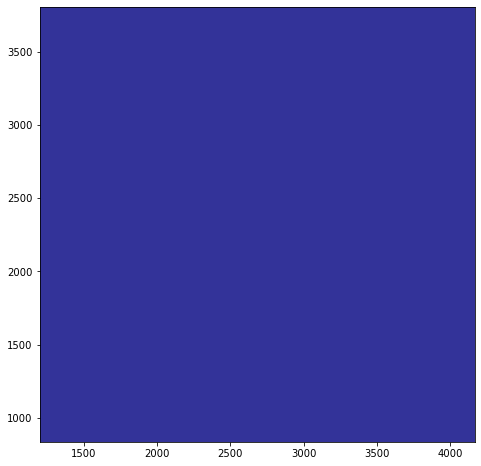

In [5]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import gdal
import glob
import os
warped = rasterio.open("myraster.tif")
fig = plt.figure(figsize=(8, 8))
show(warped, cmap="terrain")

In [6]:
drv = gdal.GetDriverByName('GTiff')
ds_in = gdal.Open('./rasters/q3r.asc')
ds_out = drv.CreateCopy('out.tif', ds_in)
srs = osr.SpatialReference()
srs.ImportFromEPSG(31254)
ds_out.SetProjection(srs.ExportToWkt())
ds_in = None
ds_out = None

./rasters/*_new.tif
['./rasters/qmid_new.tif', './rasters/q1r_new.tif', './rasters/q3r_new.tif']


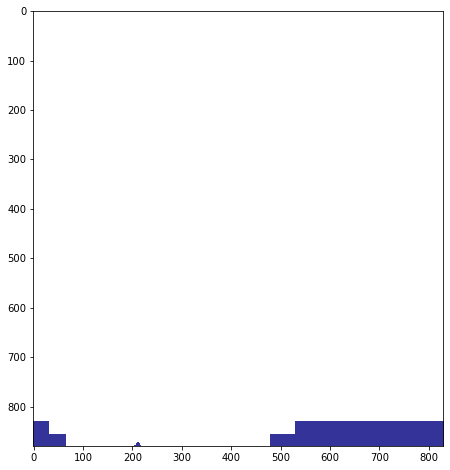

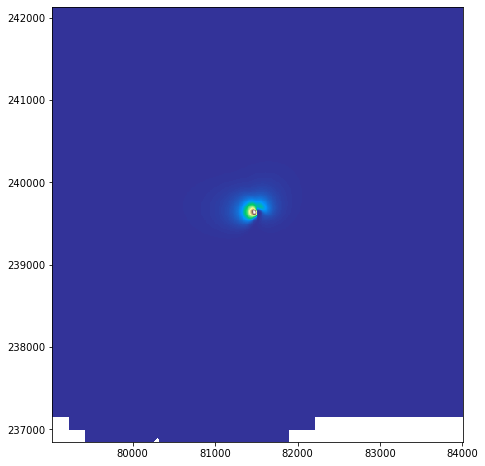

In [7]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import gdal
import glob
import os

dirpath = r"./rasters"

out_fp = r"./rasters/mosaic.tif"

search_criteria = "*_new.tif"
q = os.path.join(dirpath, search_criteria)
print(q)
dem_fps = glob.glob(q)
print(dem_fps)

src_files_to_mosaic = []

for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
mosaic, out_trans = merge(src_files_to_mosaic)
fig = plt.figure(figsize=(8, 8))
show(mosaic, cmap='terrain')
plt.show()
gdal.Warp("./rasters/x.tif", dem_fps) 

warped = rasterio.open("./rasters/x.tif")
fig = plt.figure(figsize=(8, 8))
show(warped, cmap="terrain")


In [8]:
dem_fps

['./rasters/qmid_new.tif', './rasters/q1r_new.tif', './rasters/q3r_new.tif']

In [9]:
def readFile(filename):
    filehandle = gdal.Open(filename)
    band1 = filehandle.GetRasterBand(1)
    geotransform = filehandle.GetGeoTransform()
    geoproj = filehandle.GetProjection()
    Z = band1.ReadAsArray()
    xsize = filehandle.RasterXSize
    ysize = filehandle.RasterYSize
    return xsize, ysize, geotransform, geoproj, Z

# [xsize, ysize, geotransform, geoproj, Z] = readFile(dem_fps[0])

# from scipy import stats

# m = stats.mode(Z[0])
# m

In [10]:
def asc_to_tif(q_num):
    drv = gdal.GetDriverByName('GTiff')
    in_path = "./rasters/asc_loose/q" + str(q_num) + ".asc"
    out_path = "./rasters/gen_tif/q" + str(q_num) + ".tif" 
    ds_in = gdal.Open(in_path)
    ds_out = drv.CreateCopy(out_path, ds_in)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(31254)
    ds_out.SetProjection(srs.ExportToWkt())
    ds_in = None
    ds_out = None
    

def writeFile(filename, geotransform, geoprojection, data):
    (x, y) = data.shape
    format = "GTiff"
    driver = gdal.GetDriverByName(format)
    # you can change the dataformat but be sure to be able to store negative
    # values including -9999
    dst_datatype = gdal.GDT_Float32
    dst_ds = driver.Create(filename, y, x, 1, dst_datatype)
    dst_ds.GetRasterBand(1).WriteArray(data)
    dst_ds.SetGeoTransform(geotransform)
    dst_ds.SetProjection(geoprojection)
    dst_ds.GetRasterBand(1).SetNoDataValue(-9999)
    dst_ds = None
    return 1

In [11]:
q_num_list = ["125", "250","375","500","625","750","875"]
for num in q_num_list:
    asc_to_tif(num)

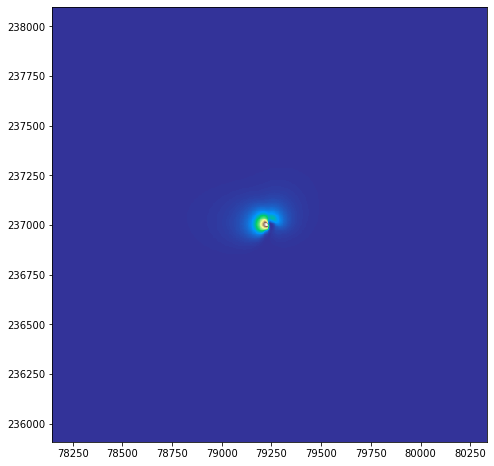

In [12]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import gdal
import glob
import os
warped = rasterio.open("./rasters/gen_tif/q500.tif")
fig = plt.figure(figsize=(8, 8))
show(warped, cmap="terrain")

In [13]:
# Apply weightings to each raster, flip along x axis
firstrun = 1

sum_weight = 10.209142568599326
weight_list = [0.668713246440564, 1.383283620084454, 1.934625982618619,
               2.162996660587738, 1.960317583701837, 1.388473977378504,
               0.710731497787608]


In [14]:
sum_weight = 10.209142568599326
weight_list = [0.668713246440564, 1.383283620084454, 1.934625982618619,
               2.162996660587738, 1.960317583701837, 1.388473977378504,
               0.710731497787608]
q_num_list = ["125", "250","375","500","625","750","875"]
for q_num in q_num_list:
    in_path = "./rasters/gen_tif/q" + str(q_num) + ".tif"
    out_path = "./rasters/proc_tif/q" + str(q_num) + ".tif"
    index = q_num_list.index(q_num)
    weight = weight_list[index]
    if firstrun == 1:
        [xsize, ysize, geotransform, geoproj, Z] = readFile(in_path)

    # # Set large negative values to -9999
    # Z[Z < 0] = -9999
    # # Set very small values to -9999
    # Z[Z < 1*10**-18] = -9999
    # # Choose your preference: (comment either rule)
    # # Z[Z == -9999] = np.nan
    # # Or
    # Apply weighting
    Z = Z * weight/sum_weight

    Z[np.isnan(Z)] = -9999
    new_geotransform = (geotransform[0], geotransform[1], geotransform[2],
              geotransform[3], geotransform[4], -1* geotransform[5])
    print(new_geotransform)
    writeFile(out_path, new_geotransform, geoproj, Z)
    
# src_files_to_mosaic = []

# for fp in dem_fps:
#     src = rasterio.open(fp)
#     src_files_to_mosaic.append(src)

(77447.73, 6.0, 0.0, 238715.68, 0.0, 6.0)
(77673.15, 5.0, 0.0, 238517.81, 0.0, 5.0)
(77925.97, 5.0, 0.0, 238292.94, 0.0, 5.0)
(78148.12, 4.0, 0.0, 238097.5, 0.0, 4.0)
(78273.77, 4.0, 0.0, 238013.08, 0.0, 4.0)
(78606.64, 4.0, 0.0, 237678.17, 0.0, 4.0)
(78899.49, 3.0, 0.0, 237440.5, 0.0, 3.0)


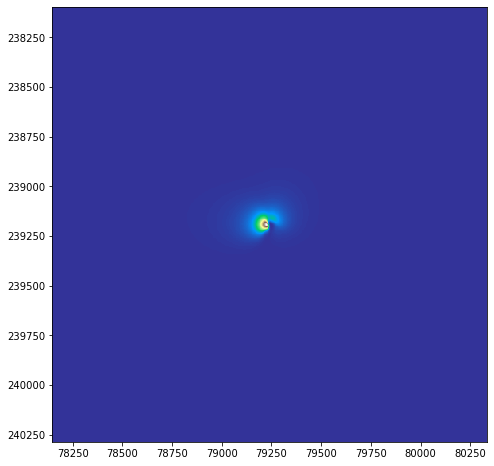

In [15]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import gdal
import glob
import os
warped = rasterio.open("./rasters/proc_tif/q500.tif")
fig = plt.figure(figsize=(8, 8))
show(warped, cmap="terrain")